# Artificial Intelligence Nanodegree - Xavier O'Rourke

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path, num_classes = 133):
    
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), num_classes)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


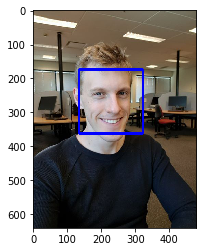

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread("images/me.jpg")
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),5)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# display the image, along with bounding box
plt.imshow(cv_rgb)
del(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

As you can see in the optput below, the face detector correctly identifies human faces about 99% of the time. When given an image of a dog it will trigger a false-positive about 12% of the time.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

from tqdm import tqdm

human_faces = 0
for img in tqdm(human_files_short):
    if face_detector(img):
        human_faces+= 1
        
dog_faces = 0
for img in tqdm(dog_files_short):
    if face_detector(img):
        dog_faces+= 1
        
# human_faces = sum([face_detector(img) for img in tqdm(human_files_short)])
# dog_faces = sum([face_detector(img) for img in tqdm(dog_files_short)])


## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
print("Number of correctly identified human faces is {}.\nNumber of false-positives on dog images is {}."
      .format(human_faces, dog_faces))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.01it/s]


Number of correctly identified human faces is 99.
Number of false-positives on dog images is 12.


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

If the purpose of this app is simple amusment, then maybe it's okay to accept photos without clear views of people's faces? (We can still pass those photos to the dog breed clasifier and get out the breed with the highest softmax activation).

However, for the purposes of my own learning I still trained a new classifier to detect whether an image contains a person. Since the cv2 CascadeClassifier does an excellent job detecting faces in images, I trained my second classifier to decide whether an image contains a pedestrian.  Many of the pedestrians in the training data aren't facing the camera or do not have their face fully visible, so this classifier should be good for detecting humans in images where the cv2.CascadeDetector fails.

To train this pedestrian detector I used the INRIA Person dataset, downloaded from http://pascal.inrialpes.fr/data/human/.

In [6]:
from keras.preprocessing import image                  
from tqdm import tqdm

# Functions for loading in data

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [7]:
from sklearn.model_selection import train_test_split

# Load file paths
pedestrian_data_train, pedestrian_targets = load_dataset("extra_data/train", num_classes = 2)
pedestrian_data_test, y_test = load_dataset("extra_data/train", num_classes = 2)

# Get tensors from file paths and split into train, test and cross validation
train_tensors = paths_to_tensor(pedestrian_data_train)
X_train, X_valid, y_train, y_valid = train_test_split(train_tensors, pedestrian_targets, test_size=0.2)
X_test = paths_to_tensor(pedestrian_data_test)

del(train_tensors)

100%|██████████████████████████████████████████████████████████████████████████████| 1832/1832 [00:19<00:00, 94.31it/s]


Let's inspect some images from the dataset:

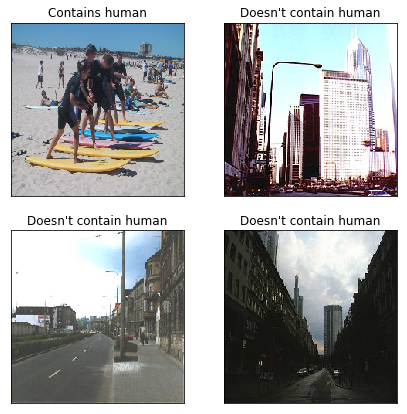

In [8]:
import copy

fig, axes = plt.subplots(2, 2, figsize=(7, 7))
for i in range(0,4):
    img = copy.deepcopy(X_train[i])
    img = img/255
    ax = axes[i//2, i%2]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img)
    if y_train[i][0] == 0:
        title = "Contains human"
    else:
        title = "Doesn't contain human"
    ax.set_title(title)
plt.show()

Since the dataset I downloaded isn't very large, I use transfer learning, based on the pretrained Resnet50 model.

In [9]:
# Compute Resnet50 features
from extract_bottleneck_features import extract_Resnet50

train_features = extract_Resnet50(X_train)
valid_features = extract_Resnet50(X_valid)
test_features = extract_Resnet50(X_test)

del(X_train)
del(X_valid)
del(X_test)

In [10]:
# Define the model

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

Resnet50_pedestrian_model = Sequential()
Resnet50_pedestrian_model.add(Flatten(input_shape=train_features.shape[1:]))
Resnet50_pedestrian_model.add(Dropout(0.5))
Resnet50_pedestrian_model.add(Dense(128, activation='relu'))
Resnet50_pedestrian_model.add(Dropout(0.5))
Resnet50_pedestrian_model.add(Dense(2, activation='softmax'))

Resnet50_pedestrian_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 262,530
Trainable params: 262,530
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Compile and train the model

Resnet50_pedestrian_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

epochs = 5

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.pedestrians.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_pedestrian_model.fit(train_features, y_train, 
          validation_data=(valid_features, y_valid),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

del(train_features)
del(valid_features)

Train on 1465 samples, validate on 367 samples
Epoch 1/5
1380/1465 [===========================>..] - ETA: 0s - loss: 0.2873 - acc: 0.9094
Epoch 1: val_loss improved from inf to 0.05243, saving model to saved_models/weights.best.pedestrians.hdf5
Epoch 2/5
1400/1465 [===========================>..] - ETA: 0s - loss: 0.0909 - acc: 0.9729
Epoch 00002: val_loss did not improve
Epoch 3/5
1420/1465 [============================>.] - ETA: 0s - loss: 0.0753 - acc: 0.9782
Epoch 00003: val_loss did not improve
Epoch 4/5
1420/1465 [============================>.] - ETA: 0s - loss: 0.0801 - acc: 0.9761
Epoch 00004: val_loss did not improve
Epoch 5/5
1460/1465 [============================>.] - ETA: 0s - loss: 0.0741 - acc: 0.9767
Epoch 00005: val_loss did not improve


Now lets see how well this classifer performs:

In [12]:
# Load the best weights
Resnet50_pedestrian_model.load_weights('saved_models/weights.best.pedestrians.hdf5')

# Compute predictions on test data
pedestrian_predictions = [np.argmax(Resnet50_pedestrian_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_features]

# Report test accuracy
test_accuracy = 100*np.sum(np.array(pedestrian_predictions)==np.argmax(y_test, axis=1))/len(pedestrian_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

del(test_features)

Test accuracy: 98.5808%


99% accuracy is definitely enough for our purposes :)

Now let's modify the ```face_detector``` function to use both classifiers.

In [13]:
import os

def face_detector(img_path):
    assert os.path.isfile(img_path), "Error: could not find file " + img_path
    img = cv2.imread(img_path)
    # First try the cv2 face_cascade classifier
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if len(face_cascade.detectMultiScale(gray)):
        return True
    # Now try the pedestrian classifer we trained
    else:
        img_features = extract_Resnet50(path_to_tensor(img_path))
        return(np.argmax(Resnet50_pedestrian_model.predict(img_features)))

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [14]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [15]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [16]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    assert os.path.isfile(img_path), "Error: could not find file " + img_path
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ As can be seen in the output below, the dog detector is extrememly accurate, correctly detecting dogs in 100% of the sample images, and only registering a false positive on 1% of the sample of human images.

In [17]:
human_faces = 0
for img in tqdm(human_files_short):
    if dog_detector(img):
        human_faces+= 1
        
dog_faces = 0
for img in tqdm(dog_files_short):
    if dog_detector(img):
        dog_faces+= 1

print("Number of correctly identified dog faces is {}.\nNumber of false-positives on human images is {}."
      .format(dog_faces, human_faces))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.04it/s]


Number of correctly identified dog faces is 100.
Number of false-positives on human images is 1.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [18]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:08<00:00, 104.07it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ I used a model which performed three sucessive 2D convolution and pooling operations, followed by two fully-connected layers. 2D convolutions are a good choice for image classification because they make use of information we have about the structure of our data (knowing which pixels are nearby which other pixels is very important!). They also give us some built-in translational invariance, which is highly desirable since we don't want our classifier to predict different dog breeds based on where abouts in the image the dog happens to be.

The max-pooling layers in between are there to reduce the number of nodes in the network while preserving the most important information from the convolutional layers below. This reduction in the number of parameters in the network makes training faster and helps avoid overfitting.

The dense layer in between the output and the final max-pool allows the network to learn non-linear relationships between the features discovered in the convolutional layers and the final descision about a dog's breed.

Dropout regularisation was found to improve problems with overfitting.

In [19]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(133, activation='softmax'))
### TODO: Define your architecture.

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 64)          0         
__________

### Compile the Model

In [20]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [21]:
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6660/6680 [============================>.] - ETA: 0s - loss: 4.8433 - acc: 0.0144
Epoch 1: val_loss improved from inf to 4.67846, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/10
6660/6680 [============================>.] - ETA: 0s - loss: 4.5582 - acc: 0.0363
Epoch 2: val_loss improved from 4.67846 to 4.35434, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/10
6660/6680 [============================>.] - ETA: 0s - loss: 4.2893 - acc: 0.0617
Epoch 3: val_loss improved from 4.35434 to 4.17848, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/10
6660/6680 [============================>.] - ETA: 0s - loss: 4.0852 - acc: 0.0859
Epoch 4: val_loss improved from 4.17848 to 4.02239, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 5/10
6660/6680 [============================>.] - ETA: 0s - loss: 3.8831 - acc: 0.1081
Epoch 5: val_loss improved from 4.02239 to 3

### Load the Model with the Best Validation Loss

In [22]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [23]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

del(train_tensors)
del(valid_tensors)
del(test_tensors)
del(model)

Test accuracy: 15.1914%


So it seems with the data and compute power available to me right now, it's very difficult to achieve high accuracy on a classifier trained from scratch.

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [24]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [25]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [26]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [27]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

del(bottleneck_features)
del(train_VGG16)
del(valid_VGG16)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6660/6680 [============================>.] - ETA: 0s - loss: 12.2496 - acc: 0.1249
Epoch 1: val_loss improved from inf to 10.75773, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
6660/6680 [============================>.] - ETA: 0s - loss: 9.9993 - acc: 0.2820 
Epoch 2: val_loss improved from 10.75773 to 9.79918, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
6660/6680 [============================>.] - ETA: 0s - loss: 9.3338 - acc: 0.3529
Epoch 3: val_loss improved from 9.79918 to 9.50594, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
6600/6680 [============================>.] - ETA: 0s - loss: 8.9296 - acc: 0.3936
Epoch 4: val_loss improved from 9.50594 to 9.13918, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 5/20
6660/6680 [============================>.] - ETA: 0s - loss: 8.6518 - acc: 0.4212
Epoch 5: val_loss improved from 9.13918 to 9.04954, saving model to 

### Load the Model with the Best Validation Loss

In [28]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [29]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

del(test_VGG16)

Test accuracy: 46.8900%


This result suggests transfer learning has the potential to yeild a much more accurate dog breed classifier.

### Predict Dog Breed with the Model

In [30]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    """ Predict breed of dog with network trained on VGG16 features"""
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [31]:
# Load pre-computed Resnet50 features for training data

bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I am using the Resnet50 model for transfer learning.

The layers of Resnet50 which we're using to extract features map images to a 1D feature vector, so there's no room for any more convolutions or pooling for the rest of the network.

So, the natural choice of architecture is a series of fully-connected layers. I experimented with 1, 2, and 3 fully connected layers, testing many different sizes of these fully-connected layers. 

The arcitecture which performed best on the cross-validation set was two fully connected layers, the first one containing 512 nodes (much larger than this led to overfitting). 

Dropout regularization also improved performance on the cross-validation data.

In [32]:
Resnet50_model = Sequential()
Resnet50_model.add(Flatten(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dropout(0.5))
Resnet50_model.add(Dense(512, activation='relu'))
Resnet50_model.add(Dropout(0.5))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 133)               68229     
Total params: 1,117,317
Trainable params: 1,117,317
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [33]:
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [34]:
### Train the model.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=10, batch_size=32, callbacks=[checkpointer], verbose=1)

del(train_Resnet50)
del(valid_Resnet50)
del(bottleneck_features)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6624/6680 [============================>.] - ETA: 0s - loss: 3.4169 - acc: 0.2491
Epoch 1: val_loss improved from inf to 1.25163, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 2/10
6560/6680 [============================>.] - ETA: 0s - loss: 1.6348 - acc: 0.5491
Epoch 2: val_loss improved from 1.25163 to 0.86722, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 3/10
6560/6680 [============================>.] - ETA: 0s - loss: 1.2355 - acc: 0.6428
Epoch 3: val_loss improved from 0.86722 to 0.71088, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 4/10
6592/6680 [============================>.] - ETA: 0s - loss: 1.0298 - acc: 0.7078
Epoch 00004: val_loss did not improve
Epoch 5/10
6624/6680 [============================>.] - ETA: 0s - loss: 0.9292 - acc: 0.7266
Epoch 5: val_loss improved from 0.71088 to 0.65708, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 6/10
6592/6680 [

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [35]:
### Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [36]:
#Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Resnet50_Predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_Predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_Predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

del(test_Resnet50)

Test accuracy: 80.2632%


80% accuracy should be high enough for our purposes :)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [37]:
def Resnet50_predict_breed(img_path):
    """Use the model based on Resnet50 features to predict the breed of a dog"""
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature, verbose = 0)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

First, I write a function to find a picture of a dog of a certain breed

In [38]:
def find_dog_picture(breed):
    """Find a random picture of a dog of the specified breed from the training dataset"""
    for folder in os.listdir("dogImages/train"):
        if(folder[4:]) == breed:
            directory = "dogImages/Train/" + folder
            path = directory + '/' + np.random.choice(os.listdir(directory))
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            return img
    print("Error: Could not find picture of this breed.")

On the first implementation, when the app was given a photo of a person it would almost always assign them one of a small number of breeds (presumably, the breeds the algorithm thought were most human-like). For example, myself, and my girlfriend, and my friend Audie were all classified as chineese cresteds (probably because we all have pale skin and light hair).

To correct this, I modified the pipeline so that on human images, instead of picking a breed based on maximum softmax activation, we use ratio between the softmax activations and the __average__ softmax activations the network spits out when given an image of a human.

These average activations are computed in the cell below.

In [39]:
features = extract_Resnet50(paths_to_tensor(human_files))
predicted_vector = Resnet50_model.predict(features, verbose = 1)
average_softmax_activations = np.mean(predicted_vector, axis = 0)
del(features)
del(predicted_vector)

100%|███████████████████████████████████████████████████████████████████████████| 13233/13233 [00:30<00:00, 430.32it/s]


Now we have everything we need to write the app. 

In [44]:
def dog_app(img_path):
    """ Predict the breed of dog in the image, or say what breed a human in the image most resembles """
    assert os.path.isfile(img_path), "Error: could not find file " + img_path
    
    img_in = cv2.imread(img_path)
    img_in = cv2.cvtColor(img_in,cv2.COLOR_BGR2RGB)
    
    # Check whether image contains a dog or a human
    if dog_detector(img_path): 
        species = "dog"
    elif face_detector(img_path):
        species = "human"
    else:
        print("Error, image does not look like dog or human!")
        return
    
    # If human, compare output activations to average
    if species == "human":
        bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
        softmax_activations = Resnet50_model.predict(bottleneck_feature, verbose = 0)
        breed = dog_names[np.argmax(softmax_activations/(average_softmax_activations + 0.0000001))]
    # For dogs we simply check the output of the network
    else:
        breed = Resnet50_predict_breed(img_path)
    
    print("Hello %s." % species)
    
    dog_img = find_dog_picture(breed)

    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img_in)
    ax2.imshow(dog_img)
    ax1.set_xticks([])
    ax2.set_xticks([])
    ax1.set_yticks([])
    ax2.set_yticks([])
    plt.show()
        
    print("You look like a %s" % breed)

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

First I try the app on some photos of my friends and I:

Hello human.


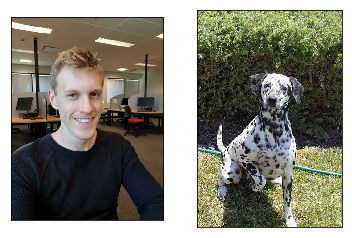

You look like a Dalmatian


In [45]:
dog_app("images/me.jpg")

Hello human.


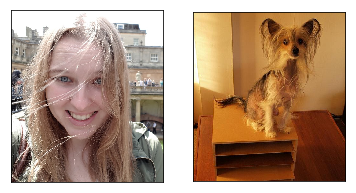

You look like a Chinese_crested


In [46]:
dog_app("images/Isabel.jpg")

Hello human.


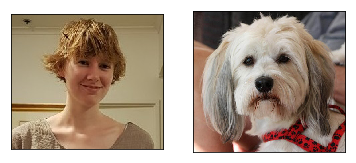

You look like a Havanese


In [47]:
dog_app("images/audie.jpg")

Hello human.


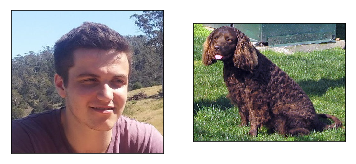

You look like a American_water_spaniel


In [48]:
dog_app("images/remy.jpg")

The results on human images are pretty amusing (I think I can see some of these resemblances) :)

Now let's try a photo where my face isn't visible (just to make sure the other human classifier is working)

Hello human.


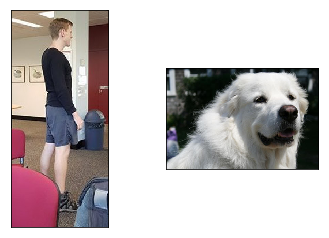

You look like a Great_pyrenees


In [49]:
dog_app("images/me-no-face.jpg")

Let's test the apps on photos of dogs (Millie, who is some kind of Australian poodle crossbreed and Alice, who is an Australian kelpie).

Hello dog.


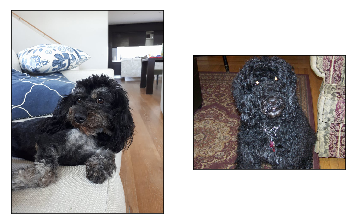

You look like a Portuguese_water_dog


In [50]:
dog_app("images/Millie.jpg")

Hello dog.


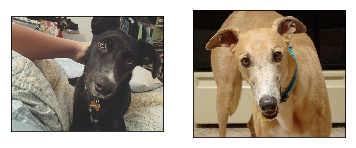

You look like a Greyhound


In [51]:
dog_app("images/alice.jpg")

Hello dog.


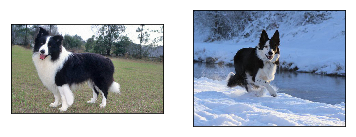

You look like a Border_collie


In [52]:
dog_app("images/border_collie.jpg")

The classifier had no hope of classifying Millie correctly (since her breed is not one of the available labels), but it picked a breed that looks very similar, which is good.

Alice (a kelpie) was also mistakenly classified, since her breed is also absent from the training data. However it made a pretty good guess again.

The classifier correctly identified the image of a border-collie I downloaded from the internet.

### Possible Improvments

Since I live in Australia, a big improvment I could make would be to collect images of Australian dogs for training. Then the classifier would have a better shot at identifying the breeds of Alice and Millie.

Another improvment to the dog app pipeline would be, when human is detected in the image, to only pass the part of the image containing the face to the dog breed classifier (so that irrelevant things like clothing and background will make a difference to the breed somebody is assigned).

The app would be much faster if the network we used to extract features was smaller than resnet50. This would probably be an improvment since in non-serious applications like this one I think speed is more important than accuracy.

Hello human.


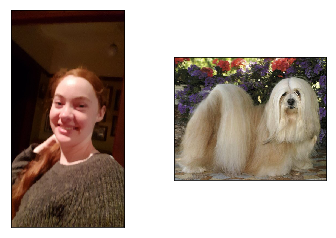

You look like a Lhasa_apso


In [53]:
dog_app("images/olivia.jpg")

Hello human.


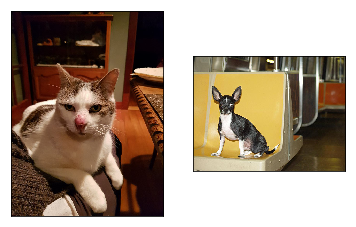

You look like a Chihuahua


In [54]:
dog_app("images/minty.jpg")

Hello human.


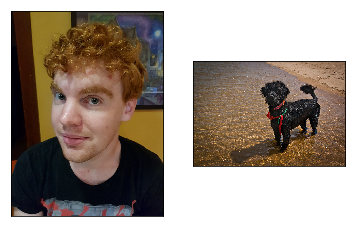

You look like a Portuguese_water_dog


In [55]:
dog_app("images/jackson.jpg")

Hello human.


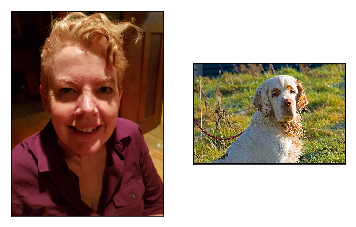

You look like a Clumber_spaniel


In [56]:
dog_app("images/jo.jpg")

Hello human.


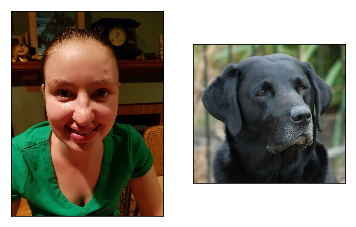

You look like a Labrador_retriever


In [57]:
dog_app("images/megan.jpg")